In [1]:
import numpy as np
import matplotlib.pyplot as plt
from obstacles import generate_scene
from shapely import Polygon

#for plotting polygons
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.collections import PatchCollection
from shapely import wkt

static_obstacles, wall_obstacles = generate_scene()

def plot_polygon(ax, poly, **kwargs):
    path = Path.make_compound_path(
        Path(np.asarray(poly.exterior.coords)[:, :2]),
        *[Path(np.asarray(ring.coords)[:, :2]) for ring in poly.interiors])

    patch = PathPatch(path, **kwargs)
    collection = PatchCollection([patch], **kwargs)
    
    ax.add_collection(collection, autolim=True)
    ax.autoscale_view()
    return collection

[[-5.7, -5.4, 0.125], [-5.7, -4.2, 0.125], [-5.7, -3.0, 0.125], [-5.7, -1.8, 0.125], [-5.7, -0.6, 0.125], [-5.7, 0.6, 0.125], [-5.7, 1.8, 0.125], [-5.7, 3.0, 0.125], [-5.7, 4.2, 0.125], [-0.9, -5.4, 0.125], [-0.9, -4.2, 0.125], [-0.9, -3.0, 0.125], [-0.9, -1.8, 0.125], [-0.9, -0.6, 0.125], [-0.9, 0.6, 0.125], [-0.9, 1.8, 0.125], [-0.9, 3.0, 0.125], [-0.9, 4.2, 0.125], [0.9, -5.4, 0.125], [0.9, -4.2, 0.125], [0.9, -3.0, 0.125], [0.9, -1.8, 0.125], [0.9, -0.6, 0.125], [0.9, 0.6, 0.125], [0.9, 1.8, 0.125], [0.9, 3.0, 0.125], [0.9, 4.2, 0.125], [5.7, -5.4, 0.125], [5.7, -4.2, 0.125], [5.7, -3.0, 0.125], [5.7, -1.8, 0.125], [5.7, -0.6, 0.125], [5.7, 0.6, 0.125], [5.7, 1.8, 0.125], [5.7, 3.0, 0.125], [5.7, 4.2, 0.125]]


In [3]:
# Load the path data from the generated text file
path_data = np.genfromtxt('data/dynamic_car_planned_pos.txt', delimiter=', ')

# Extract x, y coordinates from the path data
x_path = path_data[:, 0]
y_path = path_data[:, 1]
yaw_path = path_data[:,2]

actual_path_data = np.genfromtxt('data/robot_pos.csv', delimiter=',')
#Extract x, y coordinates from the actual path
x_actual_path = actual_path_data[:, 0]
y_actual_path = actual_path_data[:, 1]
yaw_actual_path = actual_path_data[:,2]


#geometry of the car
carLength = 0.9
carWidth = 0.4

def carPolygon(x,y,yaw): #returns a polygon for the car given a position and heading
    
    return Polygon(shell=((x + carLength/2*np.cos(yaw) + carWidth/2*np.sin(yaw), y + carLength/2*np.sin(yaw) - carWidth/2*np.cos(yaw)),
                     (x - carLength/2*np.cos(yaw) + carWidth/2*np.sin(yaw), y - carLength/2*np.sin(yaw) - carWidth/2*np.cos(yaw)),
                     (x - carLength/2*np.cos(yaw) - carWidth/2*np.sin(yaw), y - carLength/2*np.sin(yaw) + carWidth/2*np.cos(yaw)),
                     (x + carLength/2*np.cos(yaw) - carWidth/2*np.sin(yaw), y + carLength/2*np.sin(yaw) + carWidth/2*np.cos(yaw))))

def obstaclePolygon(obstacle):
    position = np.array([obstacle.position()[0], obstacle.position()[1]])
    width = obstacle.width()
    length = obstacle.length()
    return Polygon(shell=((position[0]+width/2, position[1]+length/2),
                                    (position[0]+width/2, position[1]-length/2),
                                    (position[0]-width/2, position[1]-length/2),
                                    (position[0]-width/2, position[1]+length/2)))

def wallPolygon(obstacle):
    position = np.array([obstacle.position()[0], obstacle.position()[1]])
    width = obstacle.length() #along x
    length = obstacle.width() #along y
    return Polygon(shell=((position[0]+width/2, position[1]+length/2),
                                    (position[0]+width/2, position[1]-length/2),
                                    (position[0]-width/2, position[1]-length/2),
                                    (position[0]-width/2, position[1]+length/2)))

list_intersection = []
list_cross = []

for i in range(len(x_path)):
    car_polygon = carPolygon(x_path[i], y_path[i], yaw_path[i])
    for obstacles in static_obstacles + wall_obstacles:
        obstacle_polygon = wallPolygon(obstacles)
        intersection = obstacle_polygon.intersects(car_polygon)
        #cross = car_polygon.crosses(obstacle_polygon)
        if intersection:
            print("Collision")
        #list_cross.append(cross)
    





-3.9 -3.0


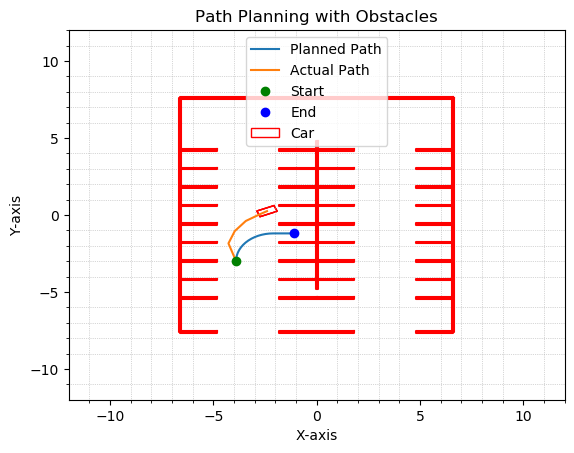

In [4]:

from matplotlib.patches import Rectangle
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
# Initialize empty plot for the car
#patch = patches.Polygon(v,closed=True, fc='r', ec='r')

# Initialize empty plot for the path
fig, ax = plt.subplots()
line1 = ax.plot(x_path, y_path, label='Planned Path')[0]
line2 = ax.plot(x_actual_path, y_actual_path, label='Actual Path')[0]

# Initialize empty plot for the car
patch = plt.Rectangle((x_path[0] - carWidth / 2, y_path[0] - carLength / 2), carWidth, carLength,
                       angle=np.degrees(yaw_path[0]), edgecolor='r', facecolor='none', label='Car')
ax.add_patch(patch)
print(x_path[0], y_path[0])
plt.plot(x_path[0], y_path[0], 'go', label = 'Start')
plt.plot(x_path[-1], y_path[-1], 'bo', label = 'End')
# Initialize obstacle plots
obstacle_plots = []
wall_plots = []

# for obstacle in static_obstacles + wall_obstacles:
#     obstacle_position = np.array([obstacle.position()[1], obstacle.position()[0]])
#     obstacle_width = obstacle.width()   #along x
#     obstacle_height = obstacle.length() #along y
#     rect = plt.Rectangle((obstacle_position[0] - obstacle_width / 2, obstacle_position[1] - obstacle_height / 2),
#                         obstacle_width, obstacle_height, color='red', alpha=0.5)
#     obstacle_plots.append(rect)
#     ax.add_patch(rect)


for obstacle in static_obstacles + wall_obstacles:
    obstacle_polygon = wallPolygon(obstacle)
    plt.plot(*obstacle_polygon.exterior.xy, color ='red')
    
# Set plot limits and labels
plt.xlim([-12, 12])
plt.ylim([-12, 12])
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Path Planning with Obstacles')
plt.legend()
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5')

def init():
    ax.add_patch(patch)
    return patch,

def animate(i):
    x1 = x_actual_path[i] - carLength/2*np.cos(yaw_actual_path[i]) + carWidth/2*np.sin(yaw_actual_path[i])
    y1 = y_actual_path[i] - carLength/2*np.sin(yaw_actual_path[i]) - carWidth/2*np.cos(yaw_actual_path[i])
    patch.set_width(carLength)
    patch.set_height(carWidth)
    patch.set_xy([x1 , y1])
    patch.angle = (yaw_actual_path[i])*180/np.pi
    return patch,

# Create the animation
anim = FuncAnimation(fig, animate,init_func=init,frames=len(x_actual_path),interval=100,blit=True)

# Display the animation
display(HTML(anim.to_jshtml()))


In [ ]:
# Plot the path
fig, ax = plt.subplots()
plt.plot(x_path, y_path, label='Planned Path', color='gray')
plt.plot(x_path[0], y_path[0], 'go', label = 'Start')
plt.plot(x_path[-1], y_path[-1], 'bo', label = 'End')
plt.plot()
#print(len(static_obstacles))
# Plot obstacles
for obstacle in static_obstacles:
    obstacle_position = np.array([obstacle.position()[0], obstacle.position()[1]])
    obstacle_width = obstacle.width()
    obstacle_height = obstacle.length()
    rect = plt.Rectangle((obstacle_position[0] - obstacle_width / 2, obstacle_position[1] - obstacle_height / 2),
                            obstacle_width, obstacle_height, color='red', alpha=0.5)
    plt.gca().add_patch(rect)
for obstacle in wall_obstacles:
    obstacle_position = np.array([obstacle.position()[1], obstacle.position()[0]])
    obstacle_width = obstacle.width()
    obstacle_height = obstacle.length()
    rect = plt.Rectangle((obstacle_position[0] - obstacle_width / 2, obstacle_position[1] - obstacle_height / 2),
                            obstacle_width, obstacle_height, color='black', alpha=0.5)
    plt.gca().add_patch(rect)
# Set plot limits and labels
plt.xlim([-12, 12])
plt.ylim([-12, 12])
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Path Planning with Obstacles')
plt.legend()
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.show()

: 

: 